# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

module_KK.py

In [ ]:
!python -m pip install --user --upgrade pip
!pip install tqdm
!pip install xgboost
!pip install lightgbm

In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [8]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)


### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### scaling of X_train and X_test by X_train_scaler
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
# X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)


### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1]) 

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                             index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
        Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
        Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [ ]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        
        
        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
#     Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
#                                  pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
#     Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']


    Autocorrelation = sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])
    Autocorrelation = Autocorrelation.T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']
    Autocorrelation = Autocorrelation.rename(index = {'lb_stat':'Test Statistics', 'lb_pvalue':'p-value'})
    
    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [ ]:
# Auto reload
%reload_ext autoreload
%autoreload 2
from module_KK import *

# Applying Base Model: Y예측을 위한 Regression분석 실행

## Code Summary (Raw Data)

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              2889.
Date:                Wed, 01 Dec 2021   Prob (F-statistic):                        0.00
Time:                        16:17:54   Log-Likelihood:                         -83421.
No. Observations:               13128   AIC:                                  1.669e+05
Df Residuals:                   13120   BIC:                                  1.669e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

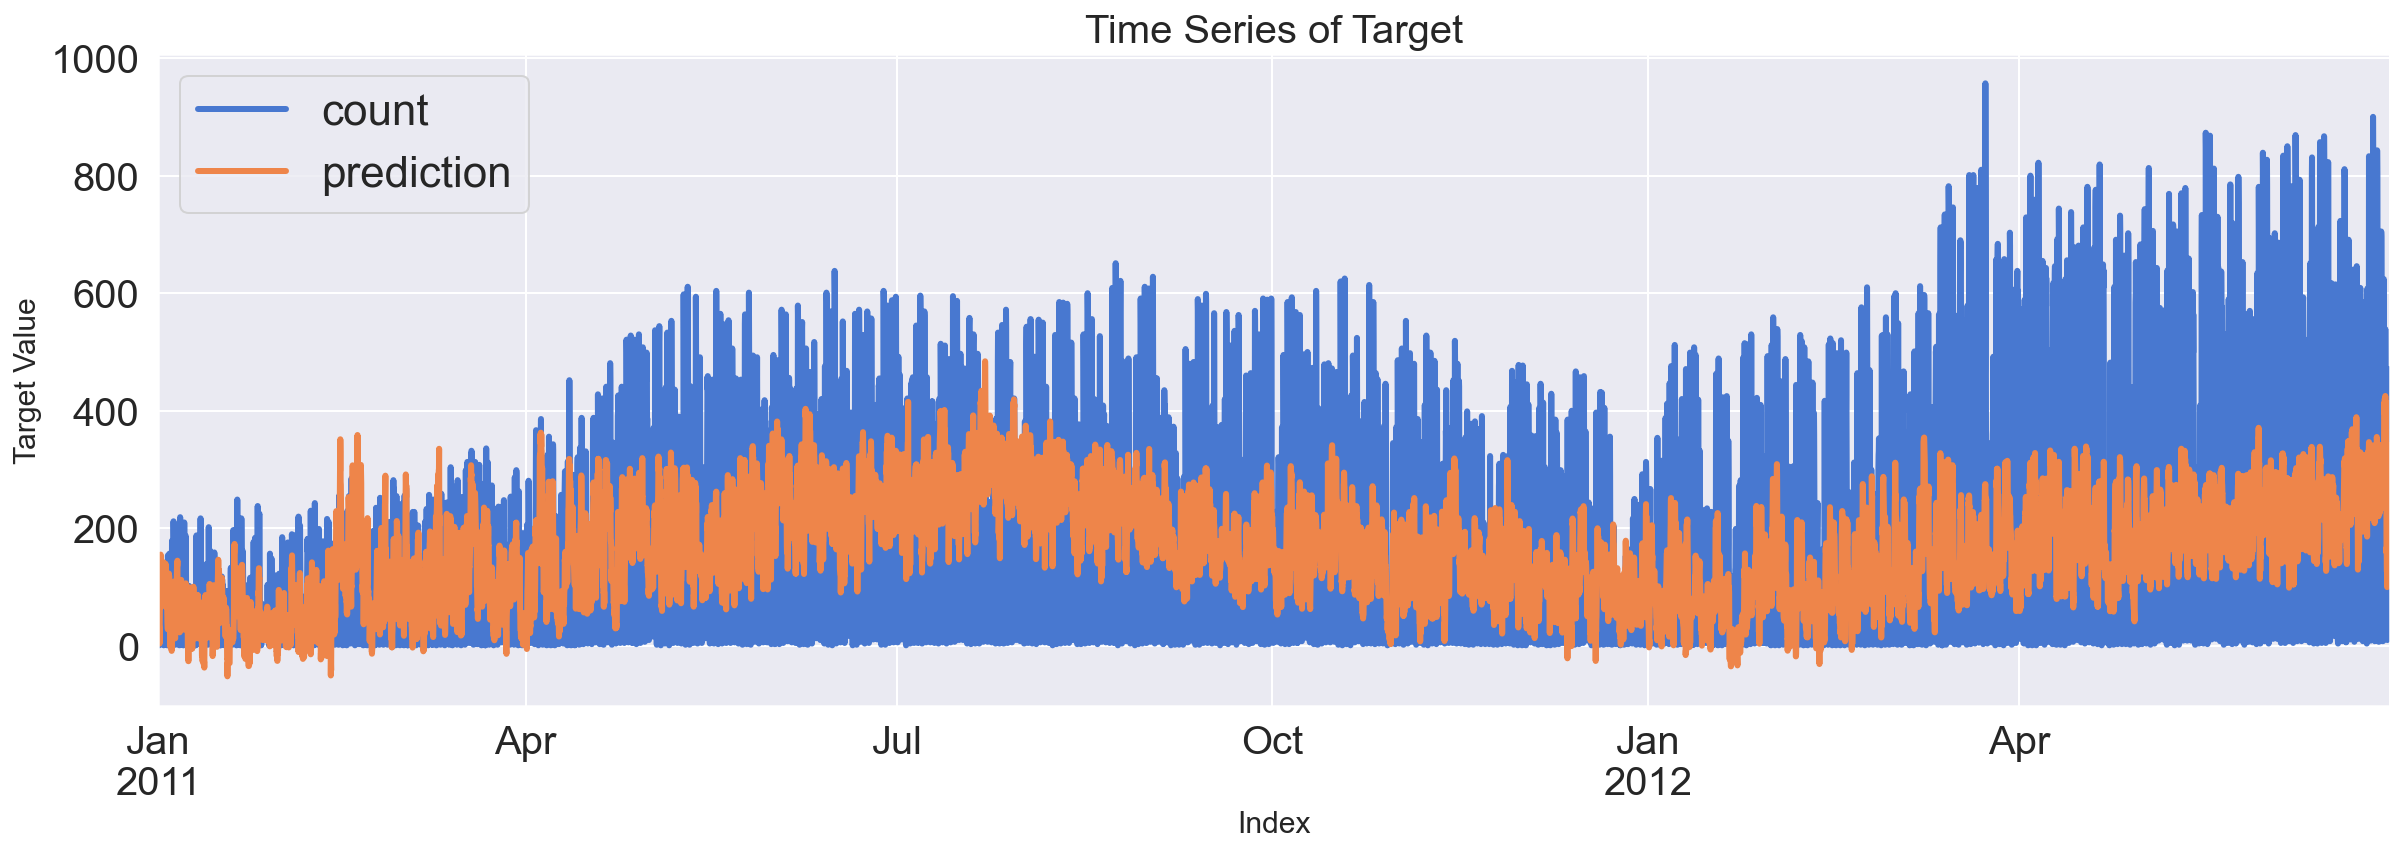

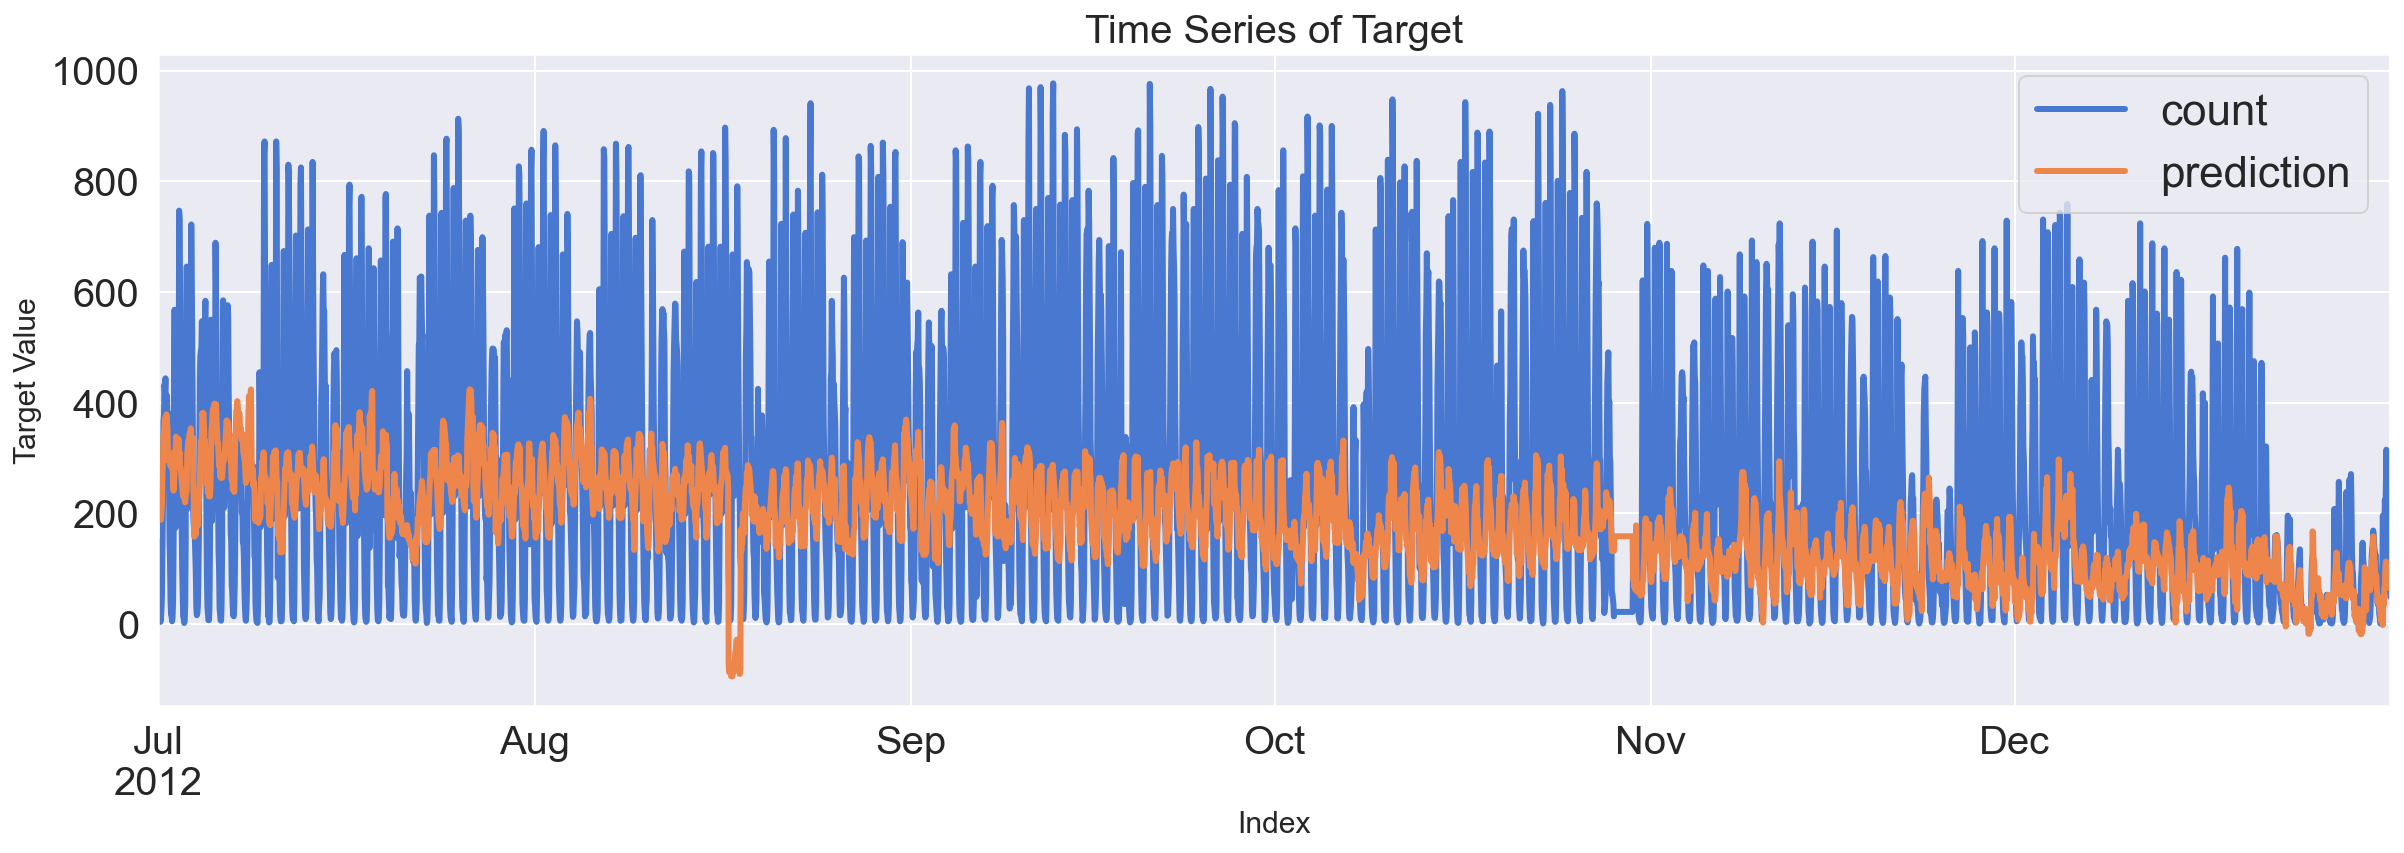

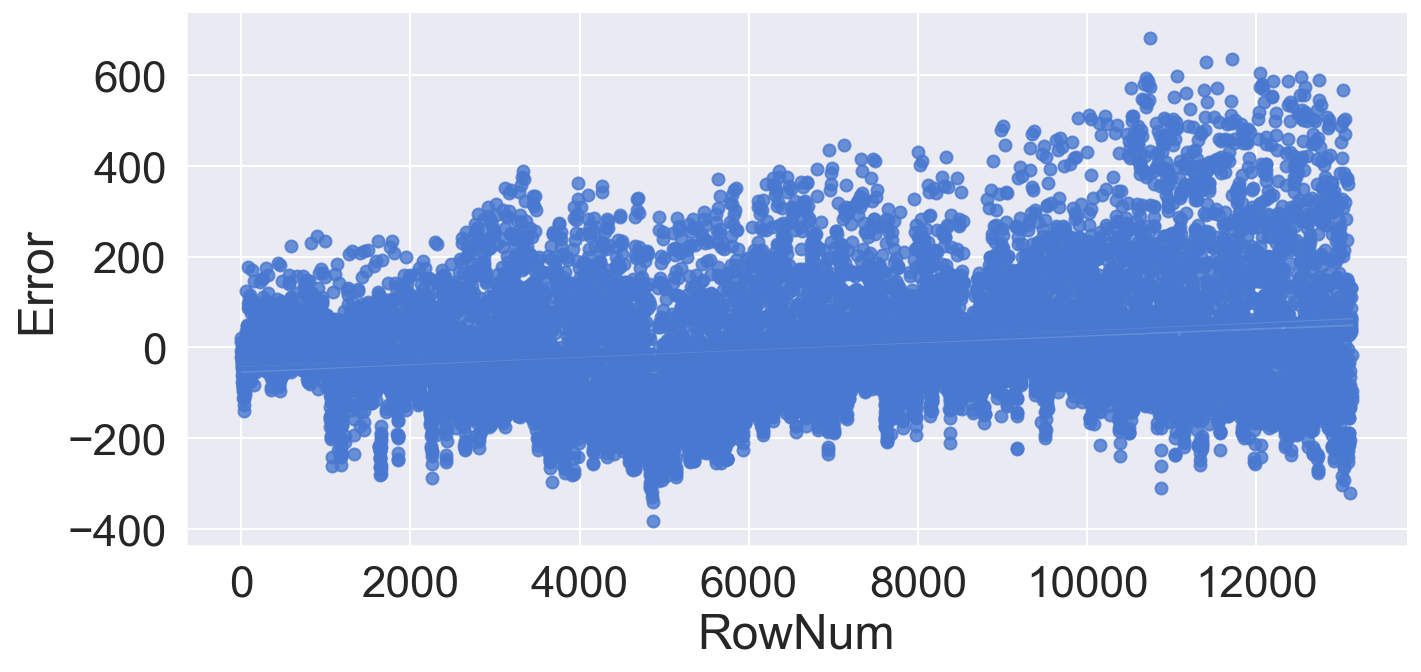

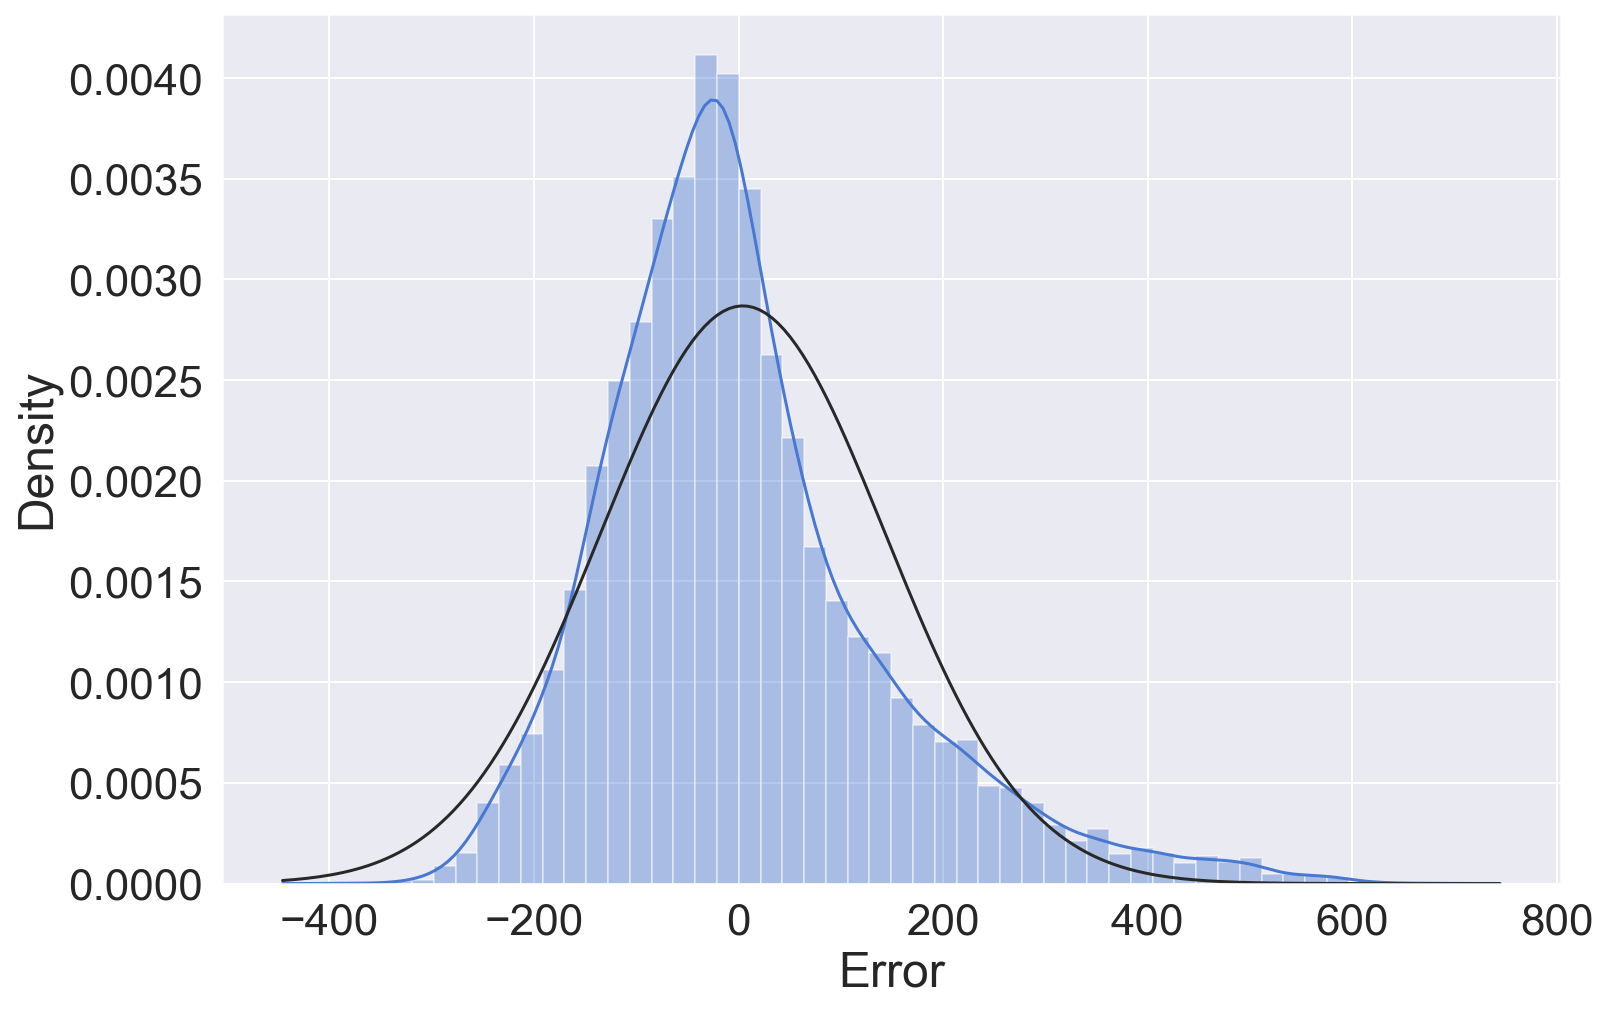

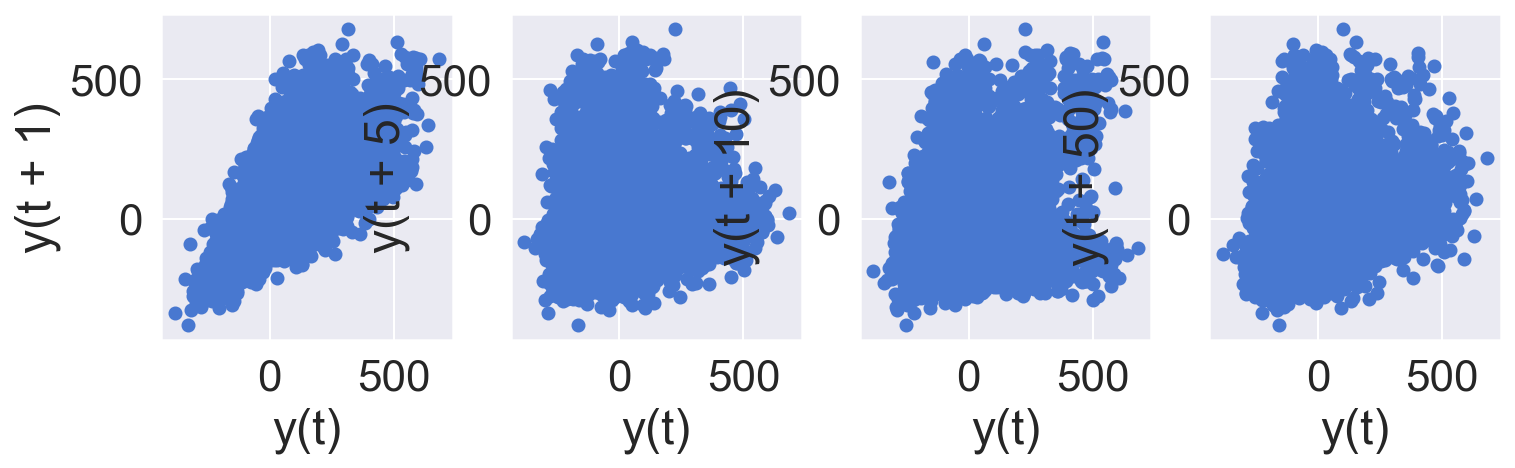

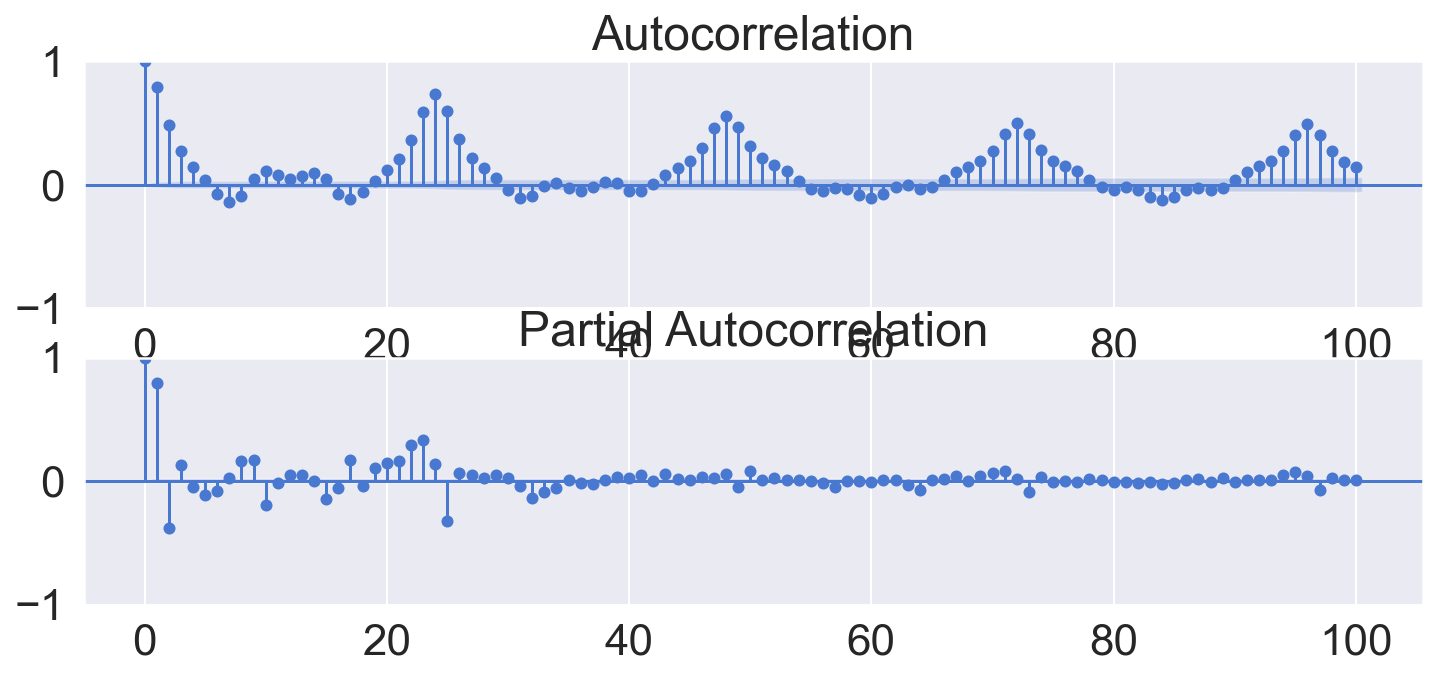

In [13]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './lecture_source/OnlineTSA-master/Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_rd = non_feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_rd.columns if x not in Y_colname+X_remove]
X_train_rd, X_test_rd, Y_train_rd, Y_test_rd = datasplit_ts(raw_rd, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
fit_reg1_rd = sm.OLS(Y_train_rd, X_train_rd).fit()
display(fit_reg1_rd.summary())
pred_tr_reg1_rd = fit_reg1_rd.predict(X_train_rd).values
pred_te_reg1_rd = fit_reg1_rd.predict(X_test_rd).values

# Evaluation
Score_reg1_rd, Resid_tr_reg1_rd, Resid_te_reg1_rd = evaluation_trte(Y_train_rd, pred_tr_reg1_rd, 
                                                                Y_test_rd, pred_te_reg1_rd, graph_on=True)
display(Score_reg1_rd)

# Error Analysis
error_analysis(Resid_tr_reg1_rd, ['Error'], X_train_rd, graph_on=True)

## Code Summary (Feature Engineering Data)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              6925.
Date:                Wed, 01 Dec 2021   Prob (F-statistic):                        0.00
Time:                        16:18:05   Log-Likelihood:                         -77008.
No. Observations:               13128   AIC:                                  1.540e+05
Df Residuals:                   13116   BIC:                                  1.541e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
count_diff      1289.2806     25.881     49.816      0.000    1238.550    1340.011
holiday         7.141e+04   1.01e+04      7.044      0.000    5.15e+04    9.13e+04
count_seasonal  1270.9307     16.107     78.906      0.000    1239.359    1302.503
Day             1151.2606    168.230      6.843      0.000     821.505    1481.017
windspeed       -234.1084    180.733     -1.295      0.195    -588.370     120.154
Quater_ver2     2.865e+04    930.475     30.787      0.000    2.68e+04    3.05e+04
Hour           -3514.0425    282.316    -12.447      0.000   -4067.422   -2960.663
weather        -2.423e+04   2238.550    -10.825      0.000   -2.86e+04   -1.98e+04
Quater_Dummy_2  6.725e+04   3436.993     19.566      0.000    6.05e+04     7.4e+04
DayofWeek       1.621e+04    912.387     17.768      0.000    1.44e+04     1.8e+04
workingday      7.695e+04   4056.717     18.970      0.000     6.9e+04    8.49e+04
count_lag2      1061.0008     14.379     73.788      0.000    1032.816    1089.186
==============================================================================
Omnibus:                     1665.324   Durbin-Watson:                   0.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5853.426
Skew:                           0.626   Prob(JB):                         0.00
Kurtosis:                       6.022   Cond. No.                     1.53e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,60.84,"7,288.40",202.42
Test,99.87,"19,151.40",153.34


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

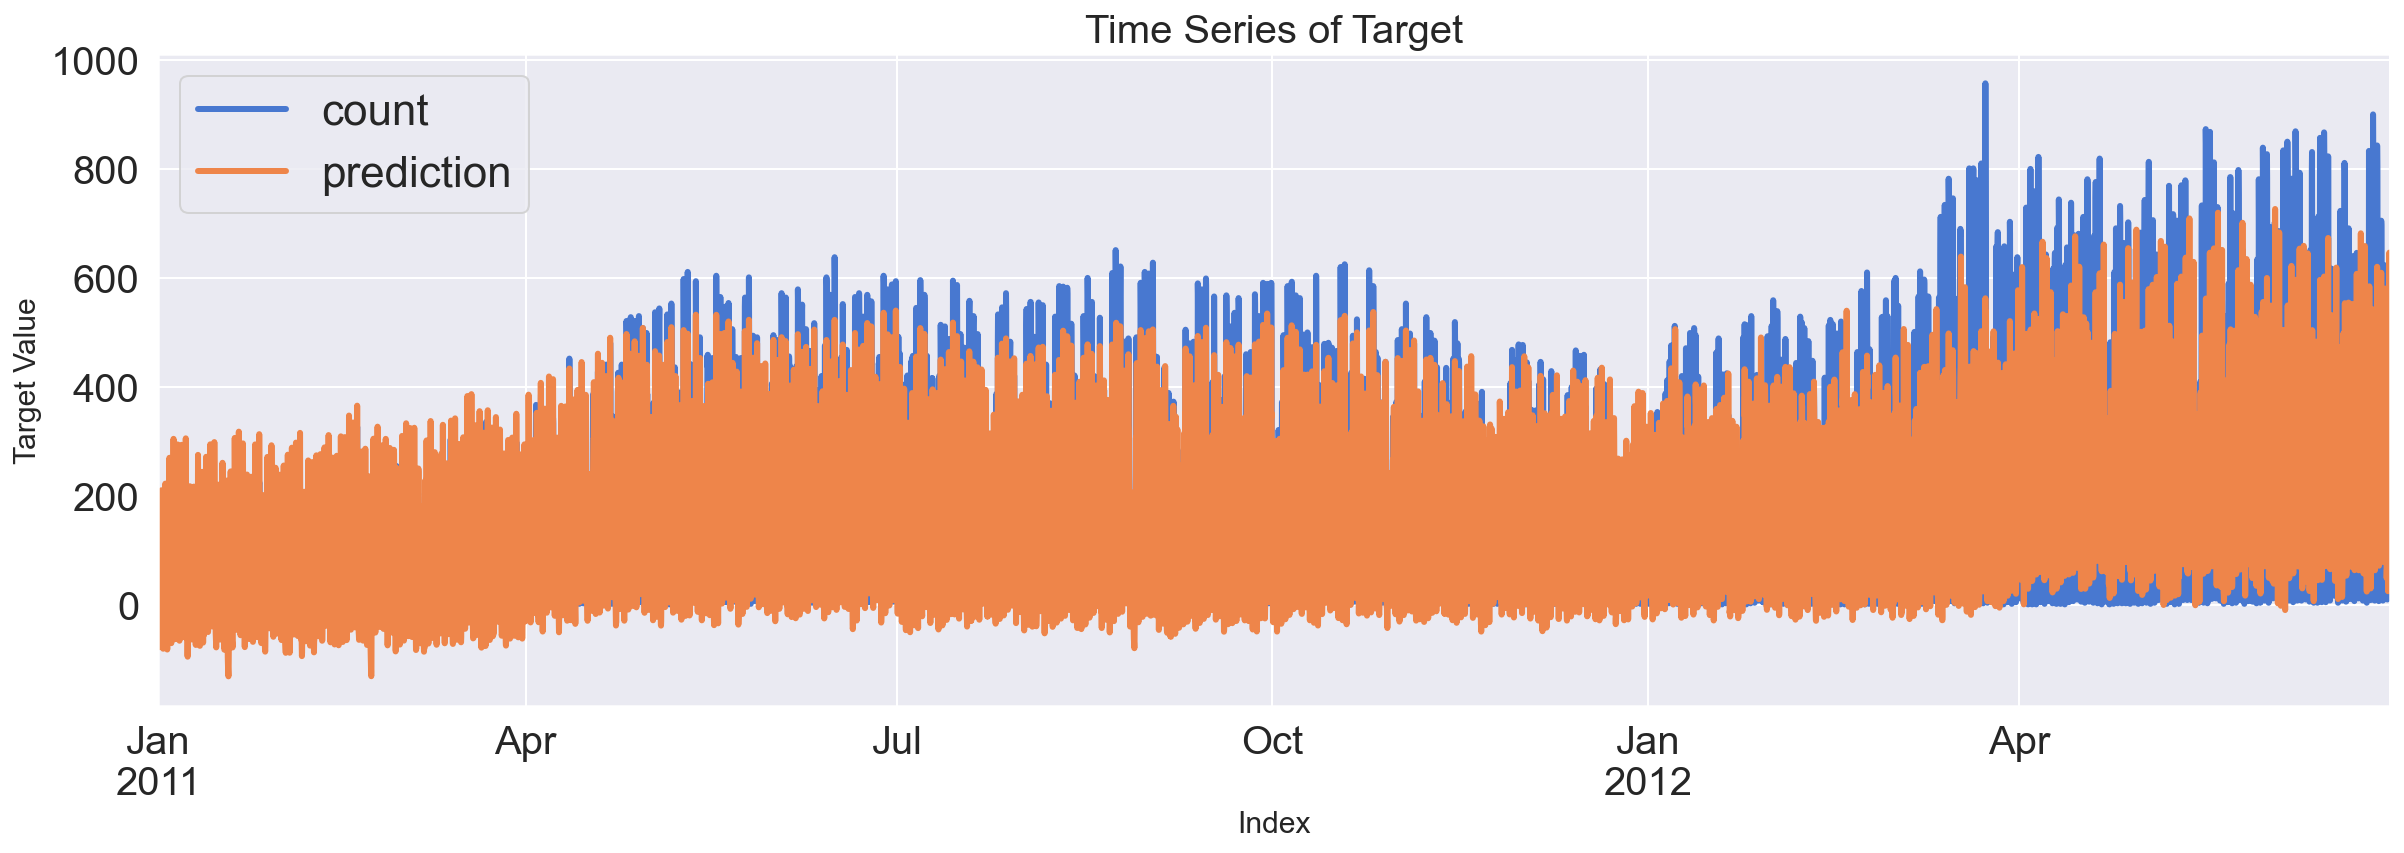

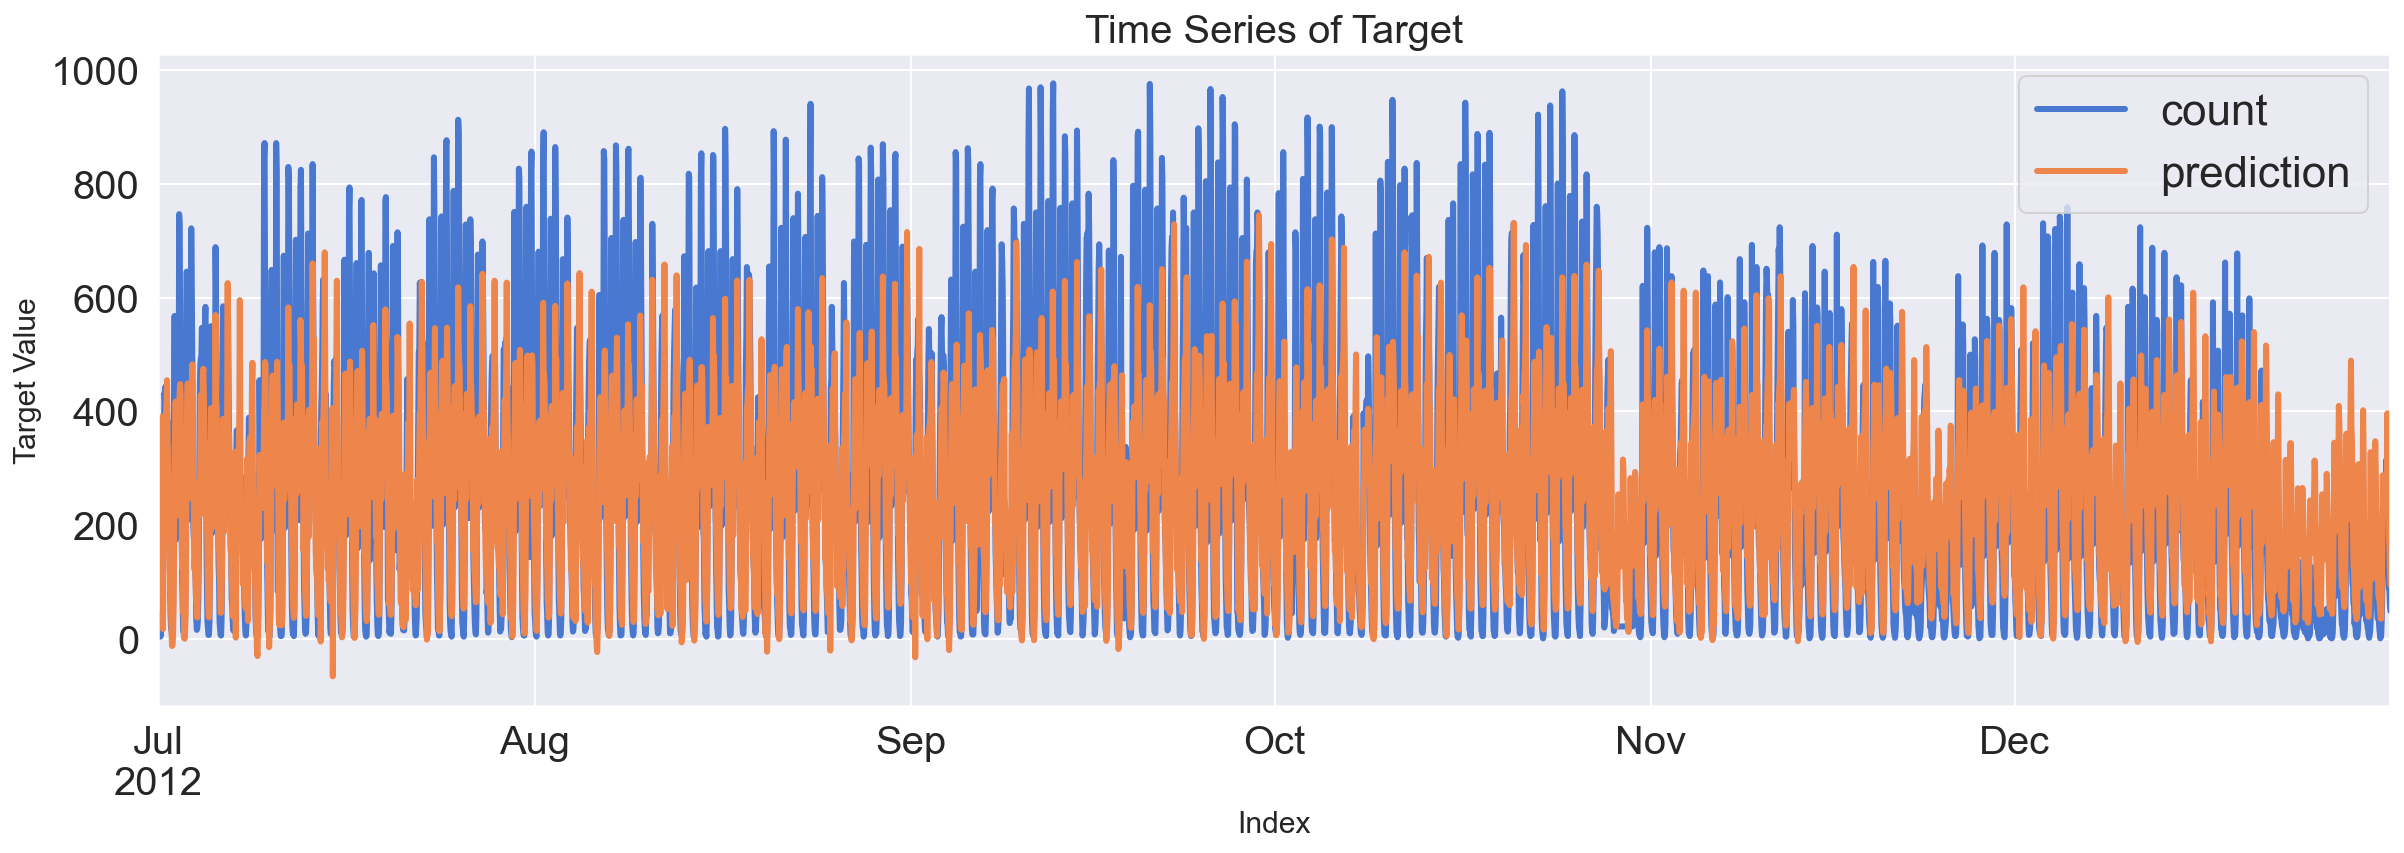

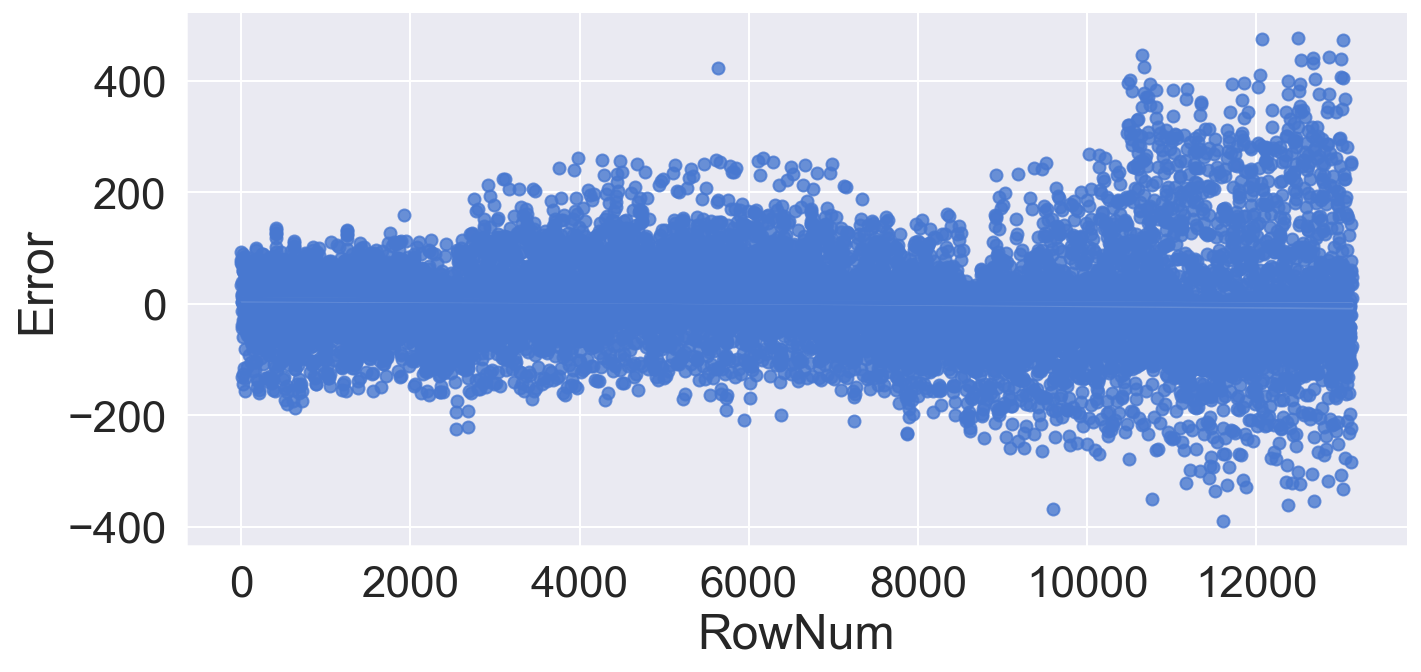

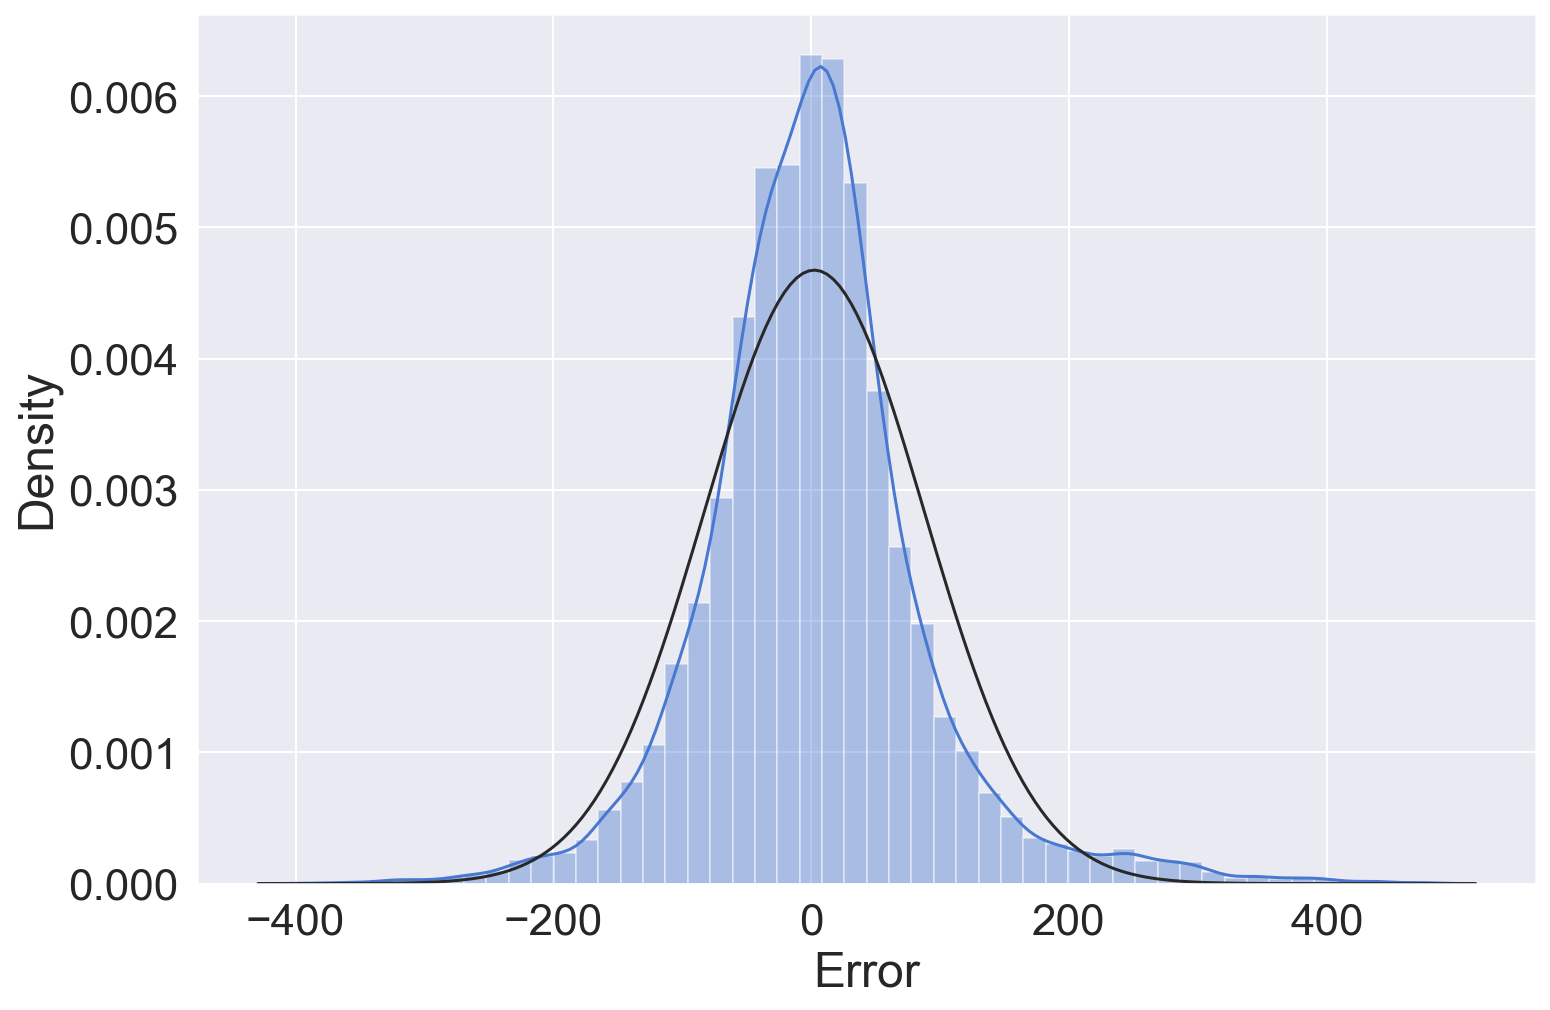

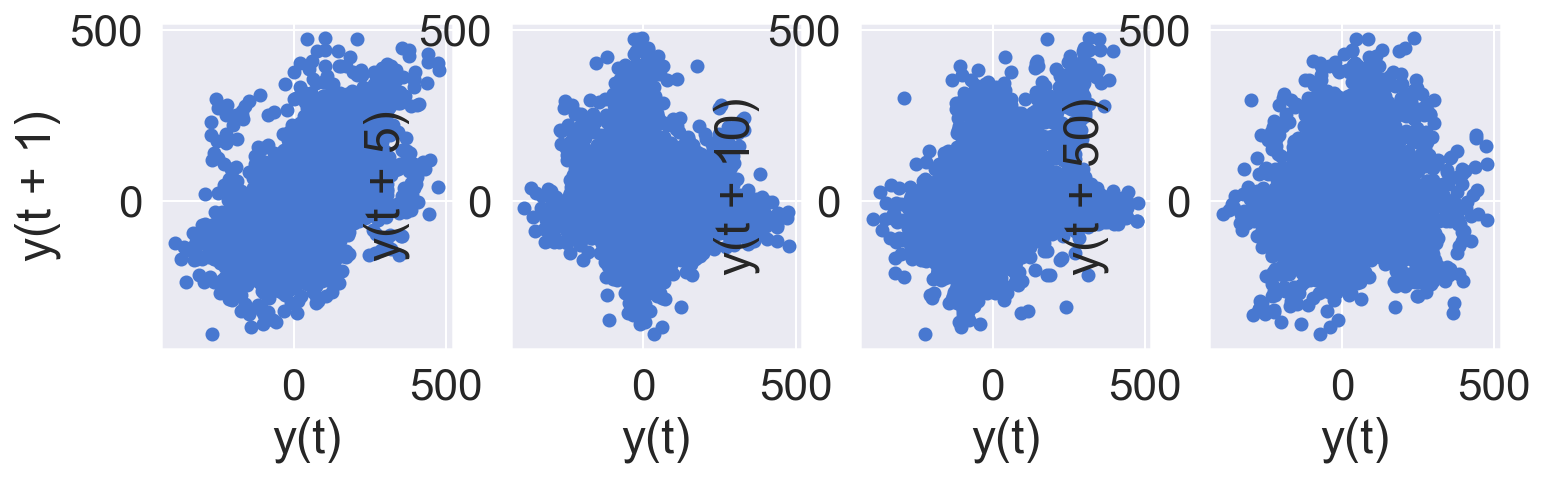

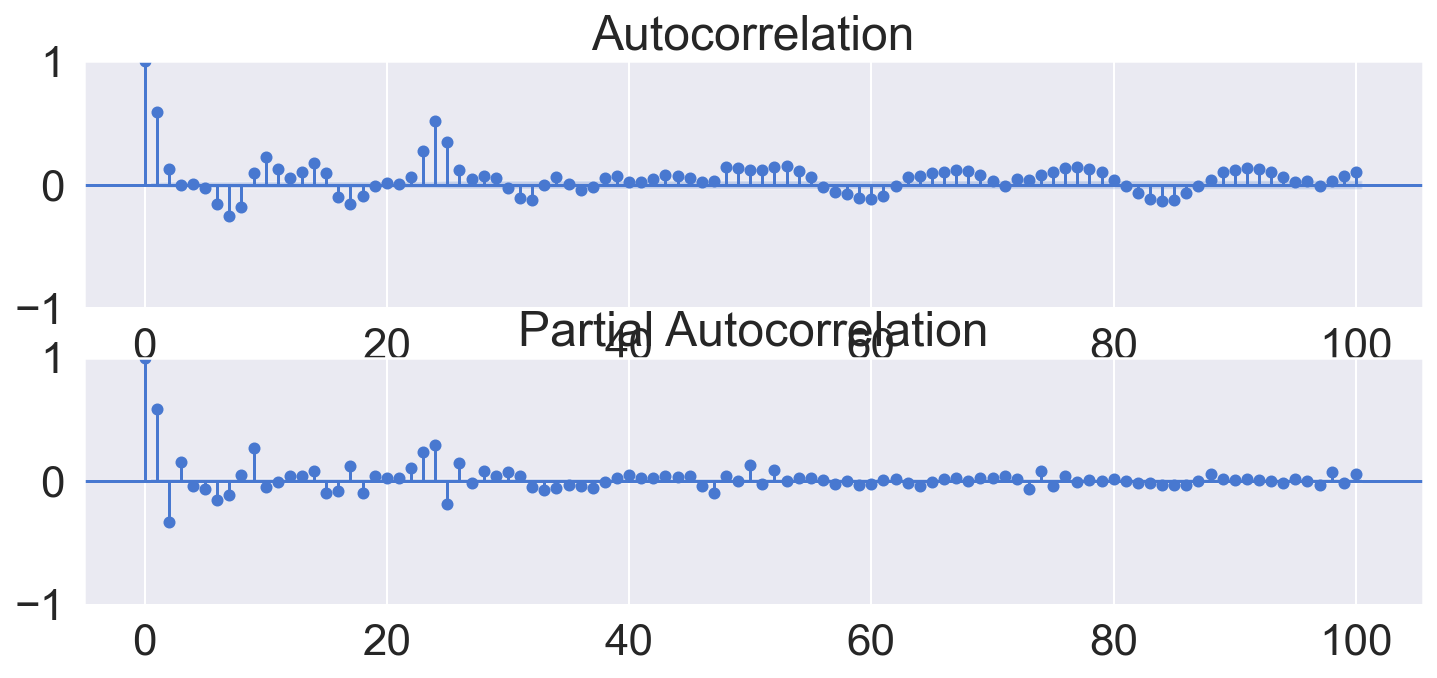

In [14]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './lecture_source/OnlineTSA-master/Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# Applying Base Model
fit_reg1_feRSM = sm.OLS(Y_train_feR, X_train_feRSM).fit()
display(fit_reg1_feRSM.summary())
pred_tr_reg1_feRSM = fit_reg1_feRSM.predict(X_train_feRSM).values
pred_te_reg1_feRSM = fit_reg1_feRSM.predict(X_test_feRSM).values

# Evaluation
Score_reg1_feRSM, Resid_tr_reg1_feRSM, Resid_te_reg1_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg1_feRSM,
                                                                   Y_test_feR, pred_te_reg1_feRSM, graph_on=True)
display(Score_reg1_feRSM)

# Error Analysis
error_analysis(Resid_tr_reg1_feRSM, ['Error'], X_train_feRSM, graph_on=True)

In [15]:
display(Score_reg1_rd)
display(Score_reg1_feRSM)

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,60.84,"7,288.40",202.42
Test,99.87,"19,151.40",153.34


# Applying Agile Model: Y예측을 위한 ML분석 실행

## Regularization

In [16]:
### Regularization
# Ridge
fit_reg2 = Ridge(alpha=0.5, fit_intercept=True, normalize=False, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg2_feRSM = fit_reg2.predict(X_train_feRSM).flatten()
pred_te_reg2_feRSM = fit_reg2.predict(X_test_feRSM).flatten()

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg2_feRSM,
                                                                   Y_test_feR, pred_te_reg2_feRSM, graph_on=False)
display(Score_reg2_feRSM)

,MAE,MSE,MAPE
Train,60.04,"7,959.30",118.70
Test,98.43,"21,413.08",88.86


In [17]:
# Lasso
fit_reg3 = Lasso(alpha=0.5, fit_intercept=True, normalize=False, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg3_feRSM = fit_reg3.predict(X_train_feRSM)
pred_te_reg3_feRSM = fit_reg3.predict(X_test_feRSM)

# Evaluation
Score_reg3_feRSM, Resid_tr_reg3_feRSM, Resid_te_reg3_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg3_feRSM,
                                                                   Y_test_feR, pred_te_reg3_feRSM, graph_on=False)
display(Score_reg3_feRSM)

,MAE,MSE,MAPE
Train,61.82,"8,437.85",97.47
Test,98.13,"22,101.64",75.46


In [18]:
# ElasticNet
fit_reg4 = ElasticNet(alpha=0.01, l1_ratio=1, fit_intercept=True, normalize=False, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg4_feRSM = fit_reg4.predict(X_train_feRSM)
pred_te_reg4_feRSM = fit_reg4.predict(X_test_feRSM)

# Evaluation
Score_reg4_feRSM, Resid_tr_reg4_feRSM, Resid_te_reg4_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg4_feRSM,
                                                                   Y_test_feR, pred_te_reg4_feRSM, graph_on=False)
display(Score_reg4_feRSM)

,MAE,MSE,MAPE
Train,58.71,"7,562.05",123.42
Test,96.85,"20,015.70",94.72


## Bagging

In [19]:
### Bagging
# DecisionTree
fit_reg5 = DecisionTreeRegressor().fit(X_train_feRSM, Y_train_feR)
pred_tr_reg5_feRSM = fit_reg5.predict(X_train_feRSM)
pred_te_reg5_feRSM = fit_reg5.predict(X_test_feRSM)

# Evaluation
Score_reg5_feRSM, Resid_tr_reg5_feRSM, Resid_te_reg5_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg5_feRSM,
                                                                   Y_test_feR, pred_te_reg5_feRSM, graph_on=False)
display(Score_reg5_feRSM)

,MAE,MSE,MAPE
Train,0.00,0.00,0.00
Test,64.73,"11,154.74",44.46


In [20]:
# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train_feRSM)
pred_te_reg6_feRSM = fit_reg6.predict(X_test_feRSM)

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

,MAE,MSE,MAPE
Train,6.54,123.38,9.11
Test,51.52,"6,749.92",40.49


## Boosting

In [21]:
### Boosting
# GradientBoostingRegression
fit_reg7 = GradientBoostingRegressor(alpha=0.1, learning_rate=0.05, loss='huber', criterion='friedman_mse',
                                           n_estimators=1000, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg7_feRSM = fit_reg7.predict(X_train_feRSM)
pred_te_reg7_feRSM = fit_reg7.predict(X_test_feRSM)

# Evaluation
Score_reg7_feRSM, Resid_tr_reg7_feRSM, Resid_te_reg7_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg7_feRSM,
                                                                   Y_test_feR, pred_te_reg7_feRSM, graph_on=False)
display(Score_reg7_feRSM)

,MAE,MSE,MAPE
Train,22.43,"1,718.49",27.51
Test,81.89,"10,774.39",167.32


In [ ]:
# XGBoost
fit_reg8 = XGBRegressor(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg8_feRSM = fit_reg8.predict(X_train_feRSM)
pred_te_reg8_feRSM = fit_reg8.predict(X_test_feRSM)

# Evaluation
Score_reg8_feRSM, Resid_tr_reg8_feRSM, Resid_te_reg8_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg8_feRSM,
                                                                   Y_test_feR, pred_te_reg8_feRSM, graph_on=False)
display(Score_reg8_feRSM)

In [ ]:
# LightGMB
fit_reg9 = LGBMRegressor(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg9_feRSM = fit_reg9.predict(X_train_feRSM)
pred_te_reg9_feRSM = fit_reg9.predict(X_test_feRSM)

# Evaluation
Score_reg9_feRSM, Resid_tr_reg9_feRSM, Resid_te_reg9_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg9_feRSM,
                                                                   Y_test_feR, pred_te_reg9_feRSM, graph_on=False)
display(Score_reg9_feRSM)

# FE Effect by Top Agile Algorithms

In [ ]:
# Raw Data
# Tatget Setting
X_train = X_train_rd.copy()
X_test = X_test_rd.copy()
Y_train = Y_train_rd.copy()

# RandomForestRegressor

fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train)
pred_te_reg6_feRSM = fit_reg6.predict(X_test)

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

In [ ]:
# FE + Reality Data
# Tatget Setting
X_train = X_train_feR.copy()
X_test = X_test_feR.copy()
Y_train = Y_train_feR.copy()

# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train)
pred_te_reg6_feRSM = fit_reg6.predict(X_test)

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

In [ ]:
# FE + Reality + Scaling Data
# Tatget Setting
X_train = X_train_feRS.copy()
X_test = X_test_feRS.copy()
Y_train = Y_train_feR.copy()

# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train)
pred_te_reg6_feRSM = fit_reg6.predict(X_test)

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

In [ ]:
# FE + Reality + Scaling + Multicolinearity Data
# Tatget Setting
X_train = X_train_feRSM.copy()
X_test = X_test_feRSM.copy()
Y_train = Y_train_feR.copy()

# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train)
pred_te_reg6_feRSM = fit_reg6.predict(X_test)

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

In [ ]:
fit_reg6.feature_importances_

In [ ]:
# Prediction Effect of Variables
Variable_Importances = pd.DataFrame([fit_reg6.feature_importances_], 
                                    columns=X_train_feRSM.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
display(Variable_Importances)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.show()

In [ ]:
# Error Analysis
error_analysis(Resid_tr_reg6_feRSM, ['Error'], X_train_feRSM, graph_on=True)